In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import torch
import torch.nn.functional as F
import scipy.ndimage
from glob import glob
from collections import defaultdict
import concurrent.futures
import datetime
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider
from ipywidgets import RadioButtons

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/luna16/sampleSubmission.csv
/kaggle/input/luna16/annotations.csv
/kaggle/input/luna16/candidates.csv
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.raw
/kaggle/input/luna16/subset2/subset2/

Loading the Dataset


In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "annotations.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "avc0706/luna16",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

First 5 records:                                            seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  


<ipython-input-4-a3229597d8ca>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [5]:
# This cell will list all files under the /kaggle/input folder.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/luna16/sampleSubmission.csv
/kaggle/input/luna16/annotations.csv
/kaggle/input/luna16/candidates.csv
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.raw
/kaggle/input/luna16/subset2/subset2/

In [6]:
# Set dataset directory based on the output from your first cell.
dataset_dir = '/kaggle/input/luna16'

# Construct full paths to the CSV files.
annotations_path = os.path.join(dataset_dir, 'annotations.csv')
candidates_path = os.path.join(dataset_dir, 'candidates.csv')

# Load CSV files into Pandas DataFrames.
annotations = pd.read_csv(annotations_path)
candidates = pd.read_csv(candidates_path)

# Display the first few rows of each DataFrame.
print("Annotations Data:")
print(annotations.head())

print("\nCandidates Data:")
print(candidates.head())

Annotations Data:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  

Candidates Data:
                                           seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   53.21 -244.41 -245.17   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.66 -121.80 

In [7]:
# Set dataset directory based on the output from your first cell.
dataset_dir = '/kaggle/input/luna16'

# This cell will iterate over directories starting with 'subset'
print("Listing files inside subset directories:")
for item in os.listdir(dataset_dir):
    # Check if the item is a subset folder
    if item.startswith('subset'):
        subset_path = os.path.join(dataset_dir, item)
        print(f"\nFiles in {item}:")
        # Walk through the folder to list files (including nested folders like the second 'subset2' folder)
        for root, _, files in os.walk(subset_path):
            for file in files:
                print(os.path.join(root, file))

Listing files inside subset directories:

Files in subset2:
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832

In [8]:
# Check for missing values in the annotations and candidates DataFrames

print("Missing values in annotations Data:")
print(annotations.isnull().sum())

print("\nMissing values in candidates Data:")
print(candidates.isnull().sum())

Missing values in annotations Data:
seriesuid      0
coordX         0
coordY         0
coordZ         0
diameter_mm    0
dtype: int64

Missing values in candidates Data:
seriesuid    0
coordX       0
coordY       0
coordZ       0
class        0
dtype: int64


In [9]:
# Calculate and print the percentage of missing values for each column in annotations DataFrame
print("\nPercentage of missing values in annotations Data:")
print((annotations.isnull().sum() / len(annotations)) * 100)

# Calculate and print the percentage of missing values for each column in candidates DataFrame
print("\nPercentage of missing values in candidates Data:")
print((candidates.isnull().sum() / len(candidates)) * 100)


Percentage of missing values in annotations Data:
seriesuid      0.0
coordX         0.0
coordY         0.0
coordZ         0.0
diameter_mm    0.0
dtype: float64

Percentage of missing values in candidates Data:
seriesuid    0.0
coordX       0.0
coordY       0.0
coordZ       0.0
class        0.0
dtype: float64


Our .Csv files have no missing values. which is expected since all inputs were verified by multiple radiologists before hand.

In [10]:
# Set dataset directory
dataset_dir = '/kaggle/input/luna16'

# Find all subset directories (they start with "subset")
subset_folders = [folder for folder in os.listdir(dataset_dir) if folder.startswith('subset')]

if subset_folders:
    print("Checking dataset subsets:")
    for subset in subset_folders:
        subset_path = os.path.join(dataset_dir, subset)
        total_files = 0
        sample_files = []
        # Walk through the subset directory to count files and store sample files.
        for root, _, files in os.walk(subset_path):
            total_files += len(files)
            # Grab up to 3 sample file paths from this directory
            for file in files:
                if len(sample_files) < 3:
                    sample_files.append(os.path.join(root, file))
        
        print(f"\n{subset}: {total_files} file(s) found.")
        if sample_files:
            print("Sample files:")
            for sample in sample_files:
                print(f"  - {sample}")
        else:
            print("  No files found in this subset.")
else:
    print("No subset directories found in the dataset directory.")

Checking dataset subsets:

subset2: 178 file(s) found.
Sample files:
  - /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
  - /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
  - /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd

subset1: 178 file(s) found.
Sample files:
  - /kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.247769845138587733933485039556.raw
  - /kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
  - /kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd

subset4: 178 file(s) found.
Sample files:
  - /kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd
  - /kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.

Checking Images Dimensions

In [11]:
# Set the dataset directory
dataset_dir = '/kaggle/input/luna16'

# Collect all .mhd image files from subset directories
mhd_files = []
for item in os.listdir(dataset_dir):
    if item.startswith('subset'):
        subset_path = os.path.join(dataset_dir, item)
        for root, _, files in os.walk(subset_path):
            for file in files:
                if file.endswith('.mhd'):
                    mhd_files.append(os.path.join(root, file))

if not mhd_files:
    print("No .mhd image files found in the dataset subsets.")
else:
    # Use the first found mhd file as a sample image
    sample_image_path = mhd_files[0]
    print("Reading image:", sample_image_path)
    
    # Read the image using SimpleITK
    image = sitk.ReadImage(sample_image_path)
    
    # Get image dimensions in voxels
    dimensions = image.GetSize()
    # Get image spacing (physical size of a voxel)
    spacing = image.GetSpacing()
    # Get the pixel type (e.g. short, float, etc.)
    pixel_type = image.GetPixelIDTypeAsString()
    
    print("Image Dimensions (voxels):", dimensions)
    print("Image Spacing (physical dimensions):", spacing)
    print("Pixel Type:", pixel_type)

Reading image: /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
Image Dimensions (voxels): (512, 512, 461)
Image Spacing (physical dimensions): (0.640625, 0.640625, 0.699999988079071)
Pixel Type: 16-bit signed integer


In [12]:
# Print current date/time and user info
print(f"Current Date and Time (UTC): {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Current User's Login: AlienBTw")

# Check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    device = torch.device("cpu")
    print("GPU is NOT available, using CPU.")

# Set dataset directory
dataset_dir = '/kaggle/input/luna16'

# Function to process a single MHD file
def process_mhd_file(file_path):
    try:
        # Read the image and get dimensions
        image = sitk.ReadImage(file_path)
        dims = image.GetSize()
        dim2d = (dims[0], dims[1])
        return dim2d, os.path.basename(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return None, file_path

# Find all MHD files
mhd_files = []
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.mhd'):
            mhd_files.append(os.path.join(root, file))

print(f"Found {len(mhd_files)} MHD files. Processing...")

# Process files in parallel
dimensions_dict = defaultdict(list)
max_workers = os.cpu_count() or 4  # Use CPU count as default

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_file = {executor.submit(process_mhd_file, file): file for file in mhd_files}
    
    # Process results as they complete
    for future in concurrent.futures.as_completed(future_to_file):
        file = future_to_file[future]
        try:
            dim2d, filename = future.result()
            if dim2d is not None:
                dimensions_dict[dim2d].append(filename)
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")

# Print results in a grouped format
print(f"\nTotal MHD files analyzed: {len(mhd_files)}")
print("\nImage dimension groups:")
for dims, file_list in dimensions_dict.items():
    print(f"{len(file_list)} images with dimensions {dims[0]}×{dims[1]}")
    
    # Show a few example filenames for each group
    if len(file_list) > 0:
        examples = file_list[:3]  # Show up to 3 examples
        print(f"  Example files: {', '.join(examples)}")
        if len(file_list) > 3:
            print(f"  ...and {len(file_list) - 3} more")
    print()

Current Date and Time (UTC): 2025-03-11 08:47:42
Current User's Login: AlienBTw
GPU is available: Tesla T4
Number of GPUs: 2
CUDA Version: 12.1
Found 1333 MHD files. Processing...

Total MHD files analyzed: 1333

Image dimension groups:
1333 images with dimensions 512×512
  Example files: 1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd, 1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd, 1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
  ...and 1330 more



Loading 3D image: /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
Image dimensions: 512×512×461


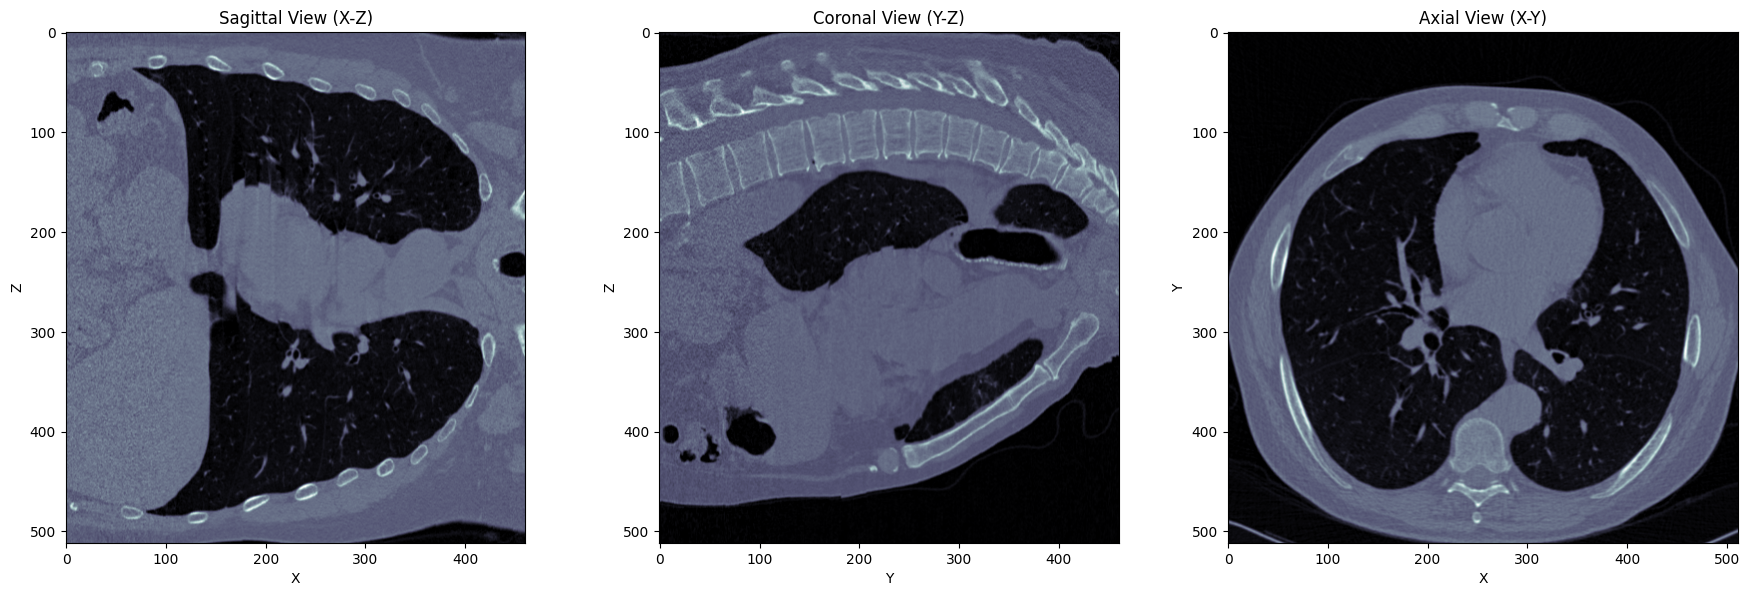

interactive(children=(IntSlider(value=230, description='Z Slice:', max=460), Output()), _dom_classes=('widget-…


3D volume rendering skipped - volume too large.
Volume size: 120848384 voxels
Consider downsampling the volume before rendering.


In [13]:
# Set dataset directory
dataset_dir = '/kaggle/input/luna16'

# Find first MHD file
mhd_file = None
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.mhd'):
            mhd_file = os.path.join(root, file)
            break
    if mhd_file:
        break

if not mhd_file:
    print("No MHD files found in the dataset.")
else:
    print(f"Loading 3D image: {mhd_file}")
    
    # Load the image
    image = sitk.ReadImage(mhd_file)
    
    # Convert to numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Get image dimensions
    depth, height, width = image_array.shape
    print(f"Image dimensions: {width}×{height}×{depth}")
    
    # Normalize for better visualization
    image_array_normalized = (image_array - image_array.min()) / (image_array.max() - image_array.min())
    
    # Create subplots
    fig = plt.figure(figsize=(18, 6))
    
    # Plot sagittal view (X-Z)
    ax1 = fig.add_subplot(131)
    sagittal_slice = np.rot90(image_array_normalized[:, height//2, :])
    ax1.imshow(sagittal_slice, cmap='bone')
    ax1.set_title('Sagittal View (X-Z)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Z')
    
    # Plot coronal view (Y-Z)
    ax2 = fig.add_subplot(132)
    coronal_slice = np.rot90(image_array_normalized[:, :, width//2])
    ax2.imshow(coronal_slice, cmap='bone')
    ax2.set_title('Coronal View (Y-Z)')
    ax2.set_xlabel('Y')
    ax2.set_ylabel('Z')
    
    # Plot axial view (X-Y)
    ax3 = fig.add_subplot(133)
    axial_slice = image_array_normalized[depth//2, :, :]
    ax3.imshow(axial_slice, cmap='bone')
    ax3.set_title('Axial View (X-Y)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()
    
    # Interactive 3D visualization with sliders
    from ipywidgets import interact, IntSlider
    
    def plot_slice(z_slice):
        plt.figure(figsize=(10, 5))
        plt.imshow(image_array_normalized[z_slice, :, :], cmap='bone')
        plt.title(f'Axial Slice {z_slice}/{depth-1}')
        plt.colorbar(label='Normalized Intensity')
        plt.tight_layout()
        plt.show()
    
    # Create an interactive slider
    interact(plot_slice, z_slice=IntSlider(min=0, max=depth-1, step=1, value=depth//2, 
                                         description='Z Slice:'))
    
    # 3D volume rendering (if the volume is not too large)
    if depth * height * width <= 64**3:  # Only try for smaller volumes
        try:
            print("\nGenerating 3D volume rendering...")
            from skimage import measure
            from mpl_toolkits.mplot3d.art3d import Poly3DCollection
            
            # Downsampling to improve performance
            ds_factor = max(1, int(max(depth, height, width) / 100))
            volume = image_array_normalized[::ds_factor, ::ds_factor, ::ds_factor]
            
            # Find threshold for tissue
            threshold = np.percentile(volume[volume > 0], 90)
            
            # Calculate vertices and faces of the isosurface
            verts, faces, _, _ = measure.marching_cubes(volume, threshold)
            
            # Create mesh
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Scale vertices to match original dimensions
            verts = verts * ds_factor
            
            # Create mesh collection
            mesh = Poly3DCollection(verts[faces])
            mesh.set_edgecolor('k')
            mesh.set_facecolor('white')
            ax.add_collection3d(mesh)
            
            # Set limits
            ax.set_xlim(0, depth // ds_factor)
            ax.set_ylim(0, height // ds_factor)
            ax.set_zlim(0, width // ds_factor)
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"3D volume rendering failed: {str(e)}")
            print("Volume might be too large or complex for rendering.")
    else:
        print("\n3D volume rendering skipped - volume too large.")
        print(f"Volume size: {depth * height * width} voxels")
        print("Consider downsampling the volume before rendering.")


Loading 3D image: /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
Original image dimensions: 512×512×461
Original volume size: 120848384 voxels
Downsampled image dimensions: 128×128×116
Downsampled volume size: 1900544 voxels
Reduction factor: 63.59x


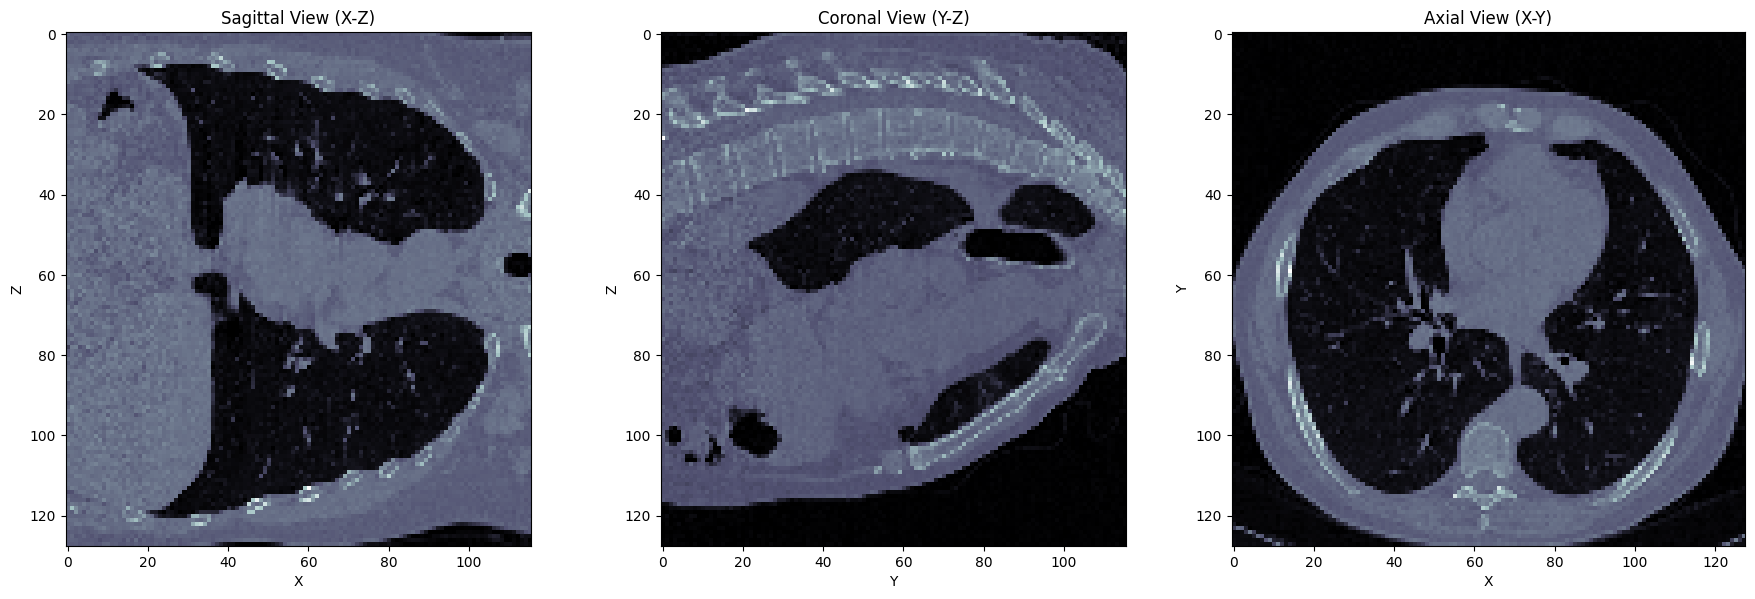

interactive(children=(IntSlider(value=58, description='Z Slice:', max=115), Output()), _dom_classes=('widget-i…


Generating 3D volume rendering with downsampled data...
Using intensity threshold: 0.4466


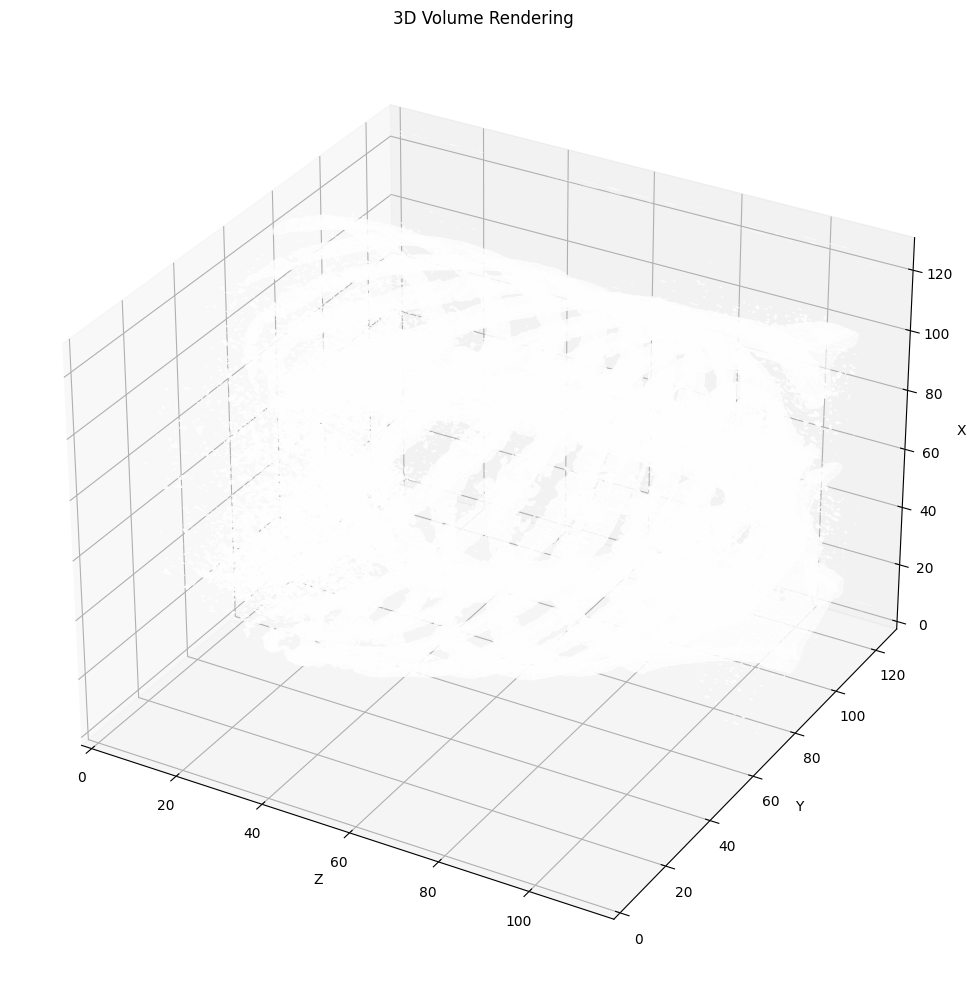

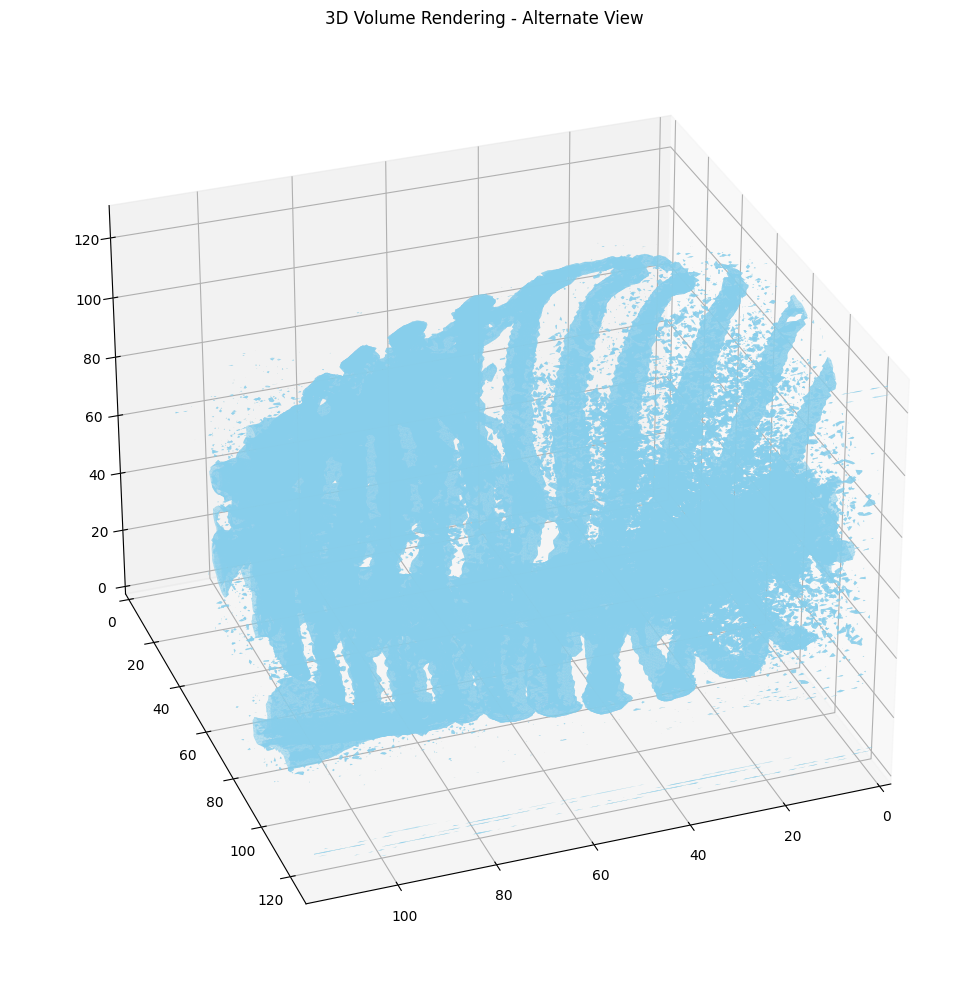

In [14]:
# Set dataset directory
dataset_dir = '/kaggle/input/luna16'

# Find first MHD file
mhd_file = None
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.mhd'):
            mhd_file = os.path.join(root, file)
            break
    if mhd_file:
        break

if not mhd_file:
    print("No MHD files found in the dataset.")
else:
    print(f"Loading 3D image: {mhd_file}")
    
    # Load the image
    image = sitk.ReadImage(mhd_file)
    
    # Convert to numpy array
    original_array = sitk.GetArrayFromImage(image)
    
    # Get original image dimensions
    orig_depth, orig_height, orig_width = original_array.shape
    print(f"Original image dimensions: {orig_width}×{orig_height}×{orig_depth}")
    print(f"Original volume size: {orig_depth * orig_height * orig_width} voxels")
    
    # Apply aggressive downsampling for 3D visualization
    # Higher ds_factor means more downsampling
    ds_factor = 4  # Adjust this based on your image size and available memory
    
    # Downsample the array
    image_array = original_array[::ds_factor, ::ds_factor, ::ds_factor]
    depth, height, width = image_array.shape
    
    print(f"Downsampled image dimensions: {width}×{height}×{depth}")
    print(f"Downsampled volume size: {depth * height * width} voxels")
    print(f"Reduction factor: {(orig_depth * orig_height * orig_width) / (depth * height * width):.2f}x")
    
    # Normalize for better visualization
    image_array_normalized = (image_array - image_array.min()) / (image_array.max() - image_array.min())
    
    # Create subplots for orthogonal views
    fig = plt.figure(figsize=(18, 6))
    
    # Plot sagittal view (X-Z)
    ax1 = fig.add_subplot(131)
    sagittal_slice = np.rot90(image_array_normalized[:, height//2, :])
    ax1.imshow(sagittal_slice, cmap='bone')
    ax1.set_title('Sagittal View (X-Z)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Z')
    
    # Plot coronal view (Y-Z)
    ax2 = fig.add_subplot(132)
    coronal_slice = np.rot90(image_array_normalized[:, :, width//2])
    ax2.imshow(coronal_slice, cmap='bone')
    ax2.set_title('Coronal View (Y-Z)')
    ax2.set_xlabel('Y')
    ax2.set_ylabel('Z')
    
    # Plot axial view (X-Y)
    ax3 = fig.add_subplot(133)
    axial_slice = image_array_normalized[depth//2, :, :]
    ax3.imshow(axial_slice, cmap='bone')
    ax3.set_title('Axial View (X-Y)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()
    
    # Interactive 3D visualization with sliders for downsampled volume
    from ipywidgets import interact, IntSlider
    
    def plot_slice(z_slice):
        plt.figure(figsize=(10, 5))
        plt.imshow(image_array_normalized[z_slice, :, :], cmap='bone')
        plt.title(f'Axial Slice {z_slice}/{depth-1}')
        plt.colorbar(label='Normalized Intensity')
        plt.tight_layout()
        plt.show()
    
    # Create an interactive slider
    interact(plot_slice, z_slice=IntSlider(min=0, max=depth-1, step=1, value=depth//2, 
                                         description='Z Slice:'))
    
    # 3D volume rendering (with aggressive thresholding to reduce complexity)
    try:
        print("\nGenerating 3D volume rendering with downsampled data...")
        from skimage import measure
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        
        # Calculate threshold - adjust these percentiles to control what gets rendered
        threshold = np.percentile(image_array_normalized[image_array_normalized > 0], 95)  # Higher percentile = less dense rendering
        
        print(f"Using intensity threshold: {threshold:.4f}")
        
        # Calculate vertices and faces of the isosurface
        verts, faces, _, _ = measure.marching_cubes(image_array_normalized, threshold)
        
        # Create mesh
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create mesh collection
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('none')  # Remove edges to simplify rendering
        mesh.set_facecolor('white')
        mesh.set_alpha(0.7)  # Add transparency
        ax.add_collection3d(mesh)
        
        # Set limits
        ax.set_xlim(0, depth)
        ax.set_ylim(0, height)
        ax.set_zlim(0, width)
        
        # Set labels
        ax.set_xlabel('Z')
        ax.set_ylabel('Y')
        ax.set_zlabel('X')
        ax.set_title('3D Volume Rendering')
        
        plt.tight_layout()
        plt.show()
        
        # Additional view from different angle
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('none')
        mesh.set_facecolor('skyblue')
        mesh.set_alpha(0.7)
        ax.add_collection3d(mesh)
        ax.view_init(elev=30, azim=70)  # Change viewpoint
        ax.set_xlim(0, depth)
        ax.set_ylim(0, height)
        ax.set_zlim(0, width)
        ax.set_title('3D Volume Rendering - Alternate View')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"3D volume rendering failed: {str(e)}")
        print("Try increasing the downsampling factor or threshold value.")
        

Loading 3D image: /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
Original image dimensions: 512×512×461
Downsampled image dimensions: 128×128×116
Reduction factor: 63.59x


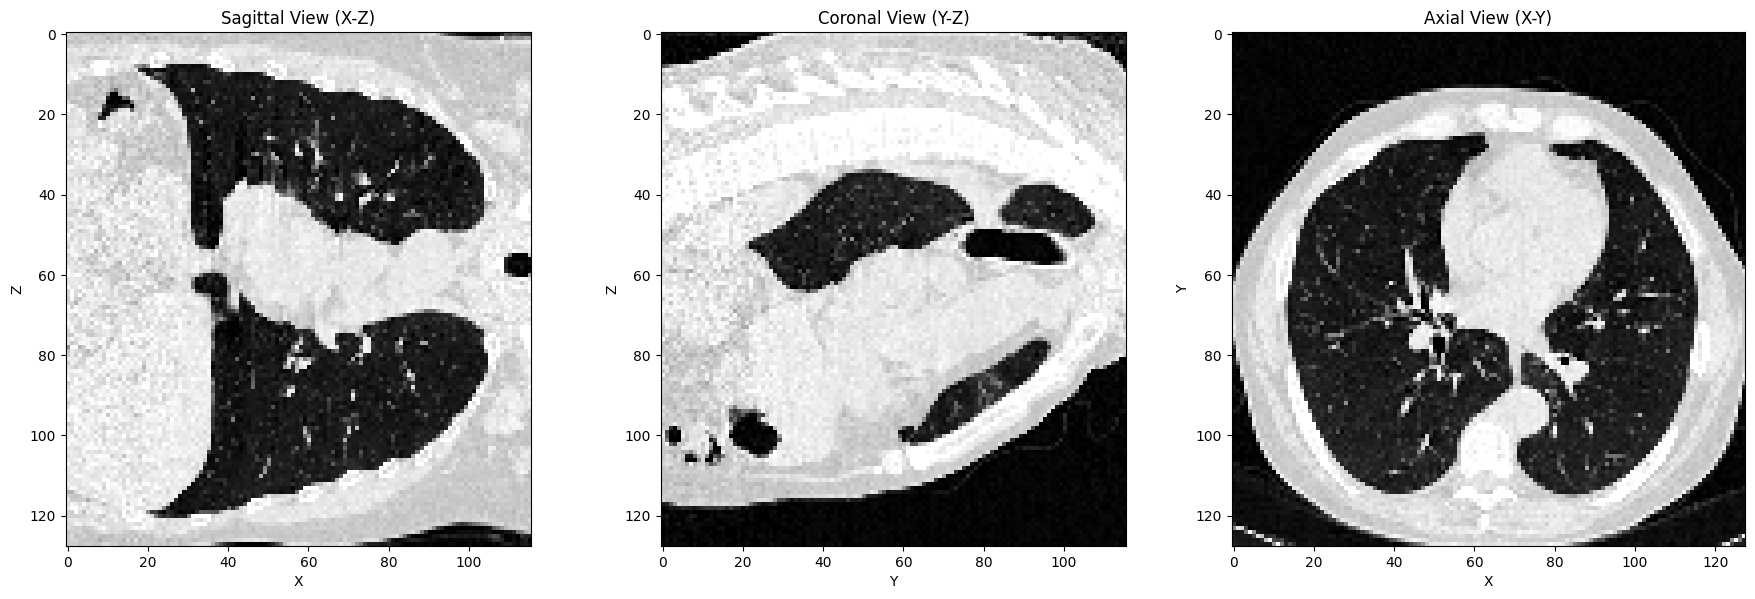


Generating Maximum Intensity Projections (MIP)...


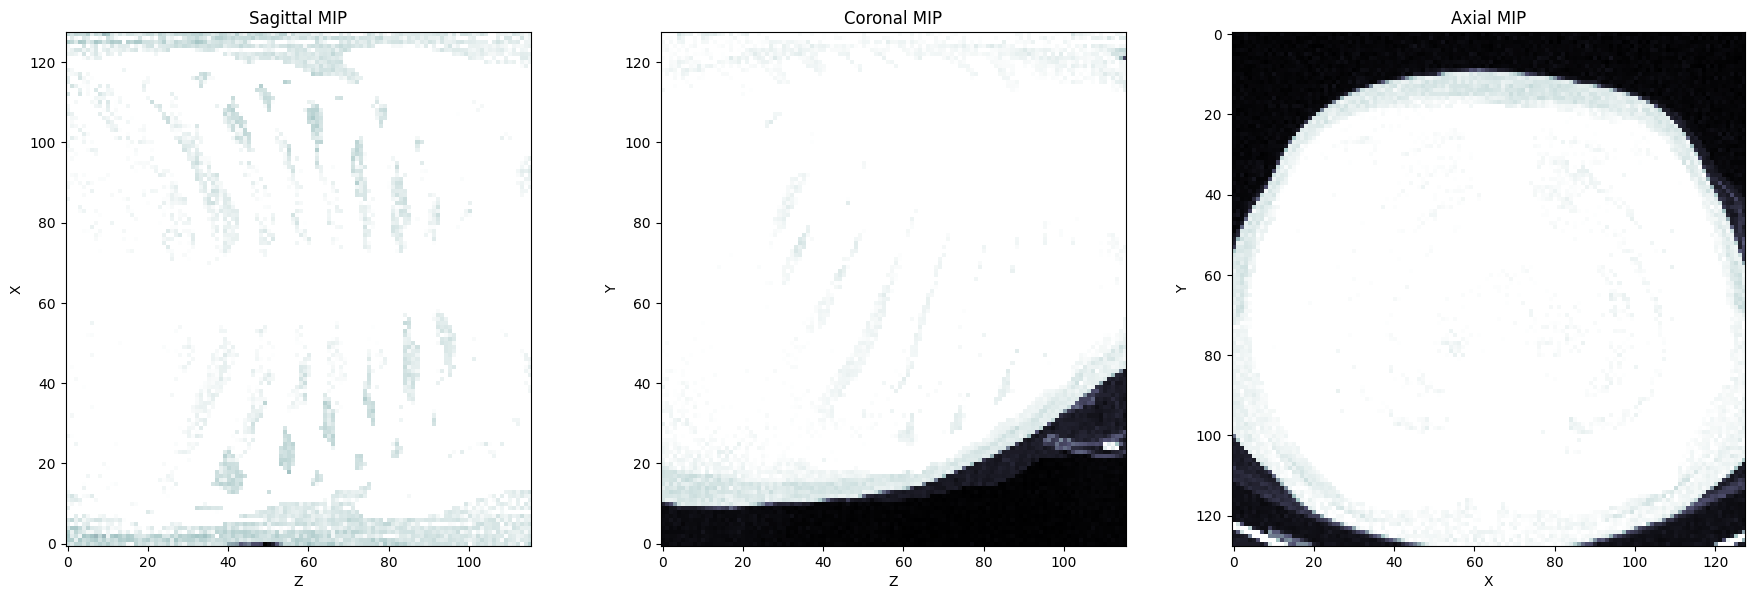

interactive(children=(RadioButtons(description='View:', options=('Axial (Z)', 'Coronal (Y)', 'Sagittal (X)'), …


Generating 3D volume rendering...


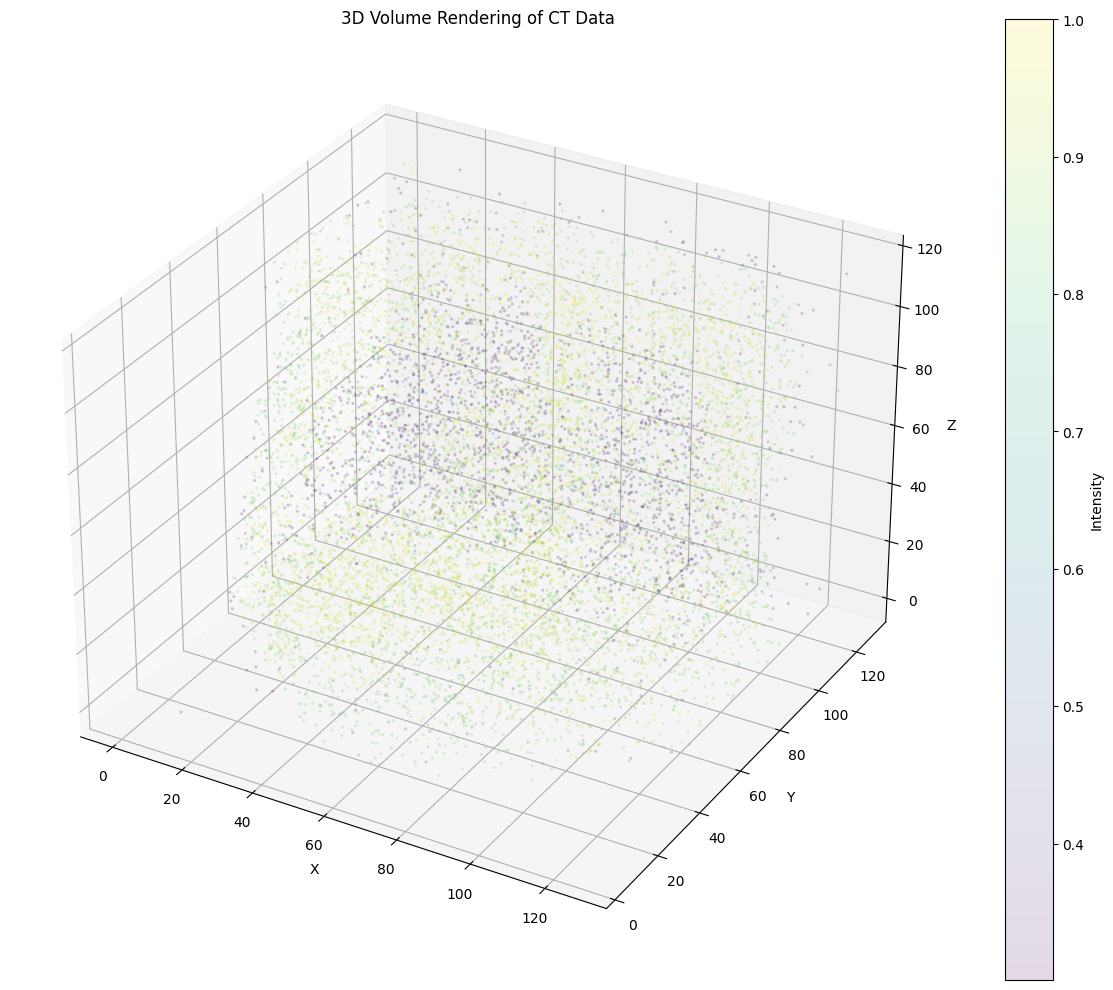

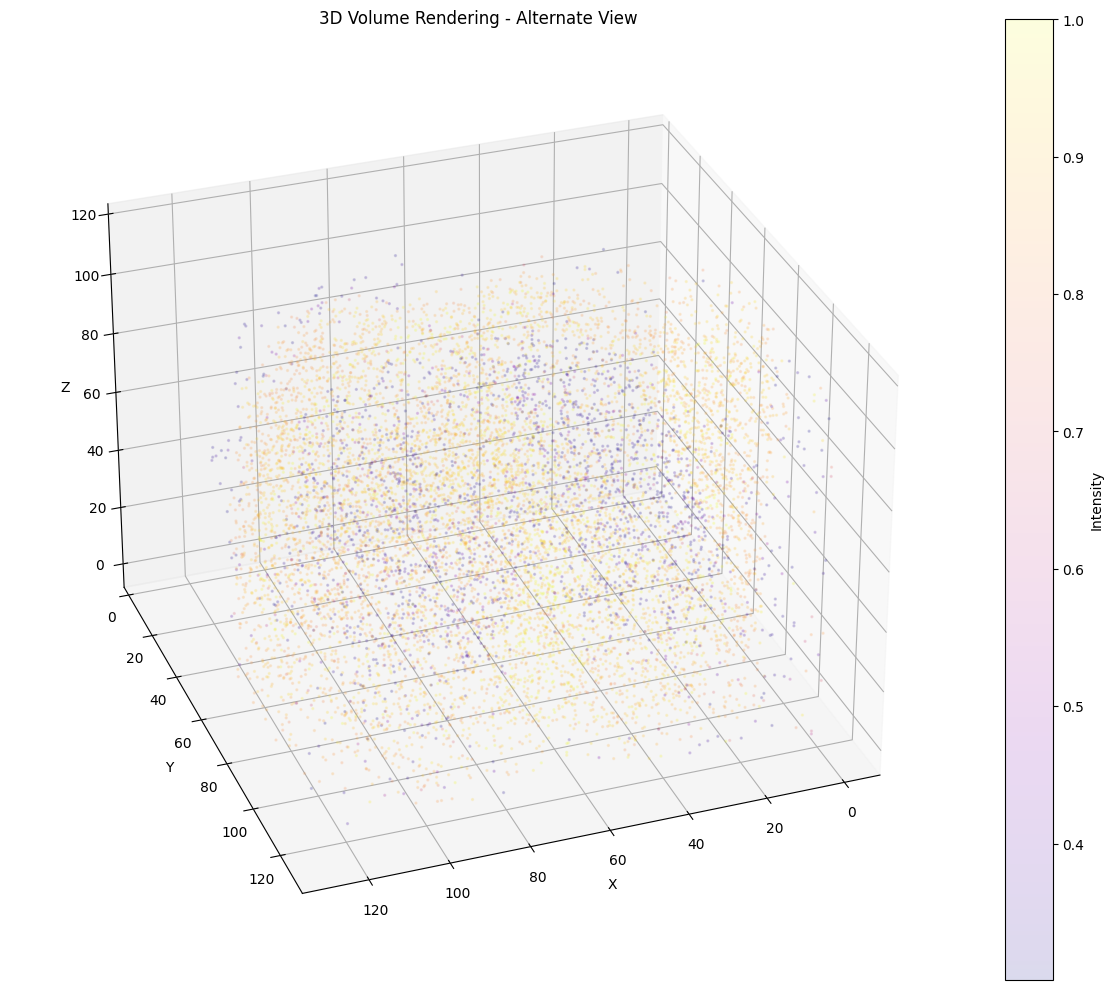

In [15]:
# Set dataset directory
dataset_dir = '/kaggle/input/luna16'

# Find first MHD file
mhd_file = None
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.mhd'):
            mhd_file = os.path.join(root, file)
            break
    if mhd_file:
        break

if not mhd_file:
    print("No MHD files found in the dataset.")
else:
    print(f"Loading 3D image: {mhd_file}")
    
    # Load the image
    image = sitk.ReadImage(mhd_file)
    
    # Convert to numpy array
    original_array = sitk.GetArrayFromImage(image)
    
    # Get original image dimensions
    orig_depth, orig_height, orig_width = original_array.shape
    print(f"Original image dimensions: {orig_width}×{orig_height}×{orig_depth}")
    
    # Apply window leveling for better CT visualization (lung window)
    # Typical lung window: center=-600, width=1500
    window_center = -600
    window_width = 1500
    
    min_value = window_center - window_width/2
    max_value = window_center + window_width/2
    
    windowed_array = np.clip(original_array, min_value, max_value)
    windowed_array = (windowed_array - min_value) / (max_value - min_value)
    
    # Apply downsampling for visualization
    ds_factor = 4
    image_array = windowed_array[::ds_factor, ::ds_factor, ::ds_factor]
    depth, height, width = image_array.shape
    
    print(f"Downsampled image dimensions: {width}×{height}×{depth}")
    print(f"Reduction factor: {(orig_depth * orig_height * orig_width) / (depth * height * width):.2f}x")
    
    # Create subplots for orthogonal views
    fig = plt.figure(figsize=(18, 6))
    
    # Plot sagittal view (X-Z)
    ax1 = fig.add_subplot(131)
    sagittal_slice = np.rot90(image_array[:, height//2, :])
    ax1.imshow(sagittal_slice, cmap='gray')
    ax1.set_title('Sagittal View (X-Z)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Z')
    
    # Plot coronal view (Y-Z)
    ax2 = fig.add_subplot(132)
    coronal_slice = np.rot90(image_array[:, :, width//2])
    ax2.imshow(coronal_slice, cmap='gray')
    ax2.set_title('Coronal View (Y-Z)')
    ax2.set_xlabel('Y')
    ax2.set_ylabel('Z')
    
    # Plot axial view (X-Y)
    ax3 = fig.add_subplot(133)
    axial_slice = image_array[depth//2, :, :]
    ax3.imshow(axial_slice, cmap='gray')
    ax3.set_title('Axial View (X-Y)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()
    
    # Create Maximum Intensity Projection (MIP) views - better for visualizing lung structures
    print("\nGenerating Maximum Intensity Projections (MIP)...")
    fig = plt.figure(figsize=(18, 6))
    
    # Sagittal MIP
    ax1 = fig.add_subplot(131)
    sagittal_mip = np.max(image_array, axis=1)  # Project along Y axis
    ax1.imshow(sagittal_mip.T, cmap='bone', origin='lower')
    ax1.set_title('Sagittal MIP')
    ax1.set_xlabel('Z')
    ax1.set_ylabel('X')
    
    # Coronal MIP
    ax2 = fig.add_subplot(132)
    coronal_mip = np.max(image_array, axis=2)  # Project along X axis
    ax2.imshow(coronal_mip.T, cmap='bone', origin='lower')
    ax2.set_title('Coronal MIP')
    ax2.set_xlabel('Z')
    ax2.set_ylabel('Y')
    
    # Axial MIP
    ax3 = fig.add_subplot(133)
    axial_mip = np.max(image_array, axis=0)  # Project along Z axis
    ax3.imshow(axial_mip, cmap='bone')
    ax3.set_title('Axial MIP')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()
    
    # Create an interactive slice viewer
    from ipywidgets import interact, IntSlider
    
    def view_slices(axis, slice_num):
        plt.figure(figsize=(10, 10))
        
        if axis == 'Axial (Z)':
            plt.imshow(image_array[slice_num, :, :], cmap='gray')
            plt.title(f'Axial Slice {slice_num}/{depth-1}')
            plt.xlabel('X')
            plt.ylabel('Y')
        elif axis == 'Coronal (Y)':
            plt.imshow(np.rot90(image_array[:, slice_num, :]), cmap='gray')
            plt.title(f'Coronal Slice {slice_num}/{height-1}')
            plt.xlabel('X')
            plt.ylabel('Z')
        else:  # Sagittal (X)
            plt.imshow(np.rot90(image_array[:, :, slice_num]), cmap='gray')
            plt.title(f'Sagittal Slice {slice_num}/{width-1}')
            plt.xlabel('Y')
            plt.ylabel('Z')
            
        plt.colorbar(label='Intensity')
        plt.tight_layout()
        plt.show()
    
    # Create interactive sliders
    from ipywidgets import RadioButtons
    
    # First select viewing axis
    def select_view(axis):
        if axis == 'Axial (Z)':
            return interact(lambda slice_num: view_slices(axis, slice_num), 
                           slice_num=IntSlider(min=0, max=depth-1, step=1, value=depth//2))
        elif axis == 'Coronal (Y)':
            return interact(lambda slice_num: view_slices(axis, slice_num),
                           slice_num=IntSlider(min=0, max=height-1, step=1, value=height//2))
        else:  # Sagittal (X)
            return interact(lambda slice_num: view_slices(axis, slice_num),
                           slice_num=IntSlider(min=0, max=width-1, step=1, value=width//2))
    
    interact(select_view, axis=RadioButtons(
        options=['Axial (Z)', 'Coronal (Y)', 'Sagittal (X)'],
        description='View:',
        disabled=False
    ))
    
    # Create 3D volume visualization using volumetric plotting
    try:
        print("\nGenerating 3D volume rendering...")
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        
        # Prepare 3D coordinates
        z, y, x = np.mgrid[:depth, :height, :width]
        
        # Filter out low-intensity voxels for better visualization
        # Adjust threshold to capture the structures of interest
        threshold = 0.3  # This value needs tuning based on your specific data
        mask = image_array > threshold
        
        # Apply mask
        x_masked = x[mask]
        y_masked = y[mask]
        z_masked = z[mask]
        values = image_array[mask]
        
        # Randomly sample points if there are too many (for performance)
        max_points = 10000
        if len(x_masked) > max_points:
            idx = np.random.choice(len(x_masked), max_points, replace=False)
            x_masked = x_masked[idx]
            y_masked = y_masked[idx]
            z_masked = z_masked[idx]
            values = values[idx]
        
        # Create 3D scatter plot colored by intensity
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Use a better colormap for CT data
        p = ax.scatter(x_masked, y_masked, z_masked, 
                      c=values, 
                      cmap='viridis', 
                      s=2,  # Small point size for better performance
                      alpha=0.15)  # Semi-transparent
        
        # Add a colorbar
        fig.colorbar(p, ax=ax, label='Intensity')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Volume Rendering of CT Data')
        
        plt.tight_layout()
        plt.show()
        
        # Create a second view from a different angle
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(x_masked, y_masked, z_masked, 
                      c=values, 
                      cmap='plasma', 
                      s=2,
                      alpha=0.15)
        fig.colorbar(p, ax=ax, label='Intensity')
        ax.view_init(elev=30, azim=70)  # Change viewpoint
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Volume Rendering - Alternate View')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"3D volume rendering failed: {str(e)}")
        print("Try adjusting the threshold or increasing downsampling")